Example Lap Analysis Using FormulaPy's Ergast API
---
[Ergast](http://ergast.com/mrd/) implements a REST API for accessing their database for F1 and Formula E. They also provide a mysql database file, but this requires that you setup mysql. This library will support the database access, but for now supports the REST API, which makes it easier for anyone to get up and running with the library.

#####Approach
FormulaPy generally implements python classes to represent the different concepts implemented by Ergast and/or formula racing. By using classes for the api, instead of just raw tables retrieved by simple functions or queries, convenience methods can be added to produce charts, and/or dynamically add additional data that isn't included in the Ergast data set. Additionally, what could be a sequence of steps/queries, can be or will be available through simple dot ('.') notation, which supports more exploratory browsing. For example, `f1.seasons.s2015.<tab>`, would dynamically query Ergast for the list of races for 2015, and most IDEs/REPLs will present the user with what is available. Then, you can drill down to more elements through dot notation to get to more specific information.

Once you drill down to what you want, you can access the table of data as a [Pandas DataFrame](http://pandas.pydata.org/pandas-docs/dev/10min.html). Or, you can utilize the convenience methods for directly producing charts, using the subset of data. This notebook demonstrates some of these concepts.

#####Running
FormulaPy is not a python package, but will be after it matures a bit more. For now, the easiest way to get started is to install Anaconda, then clone the FormulaPy github repository. There may be additional dependencies (beyond Anaconda's base install) required to install via: `pip install LIBRARY_NAME`, such as:
* lazy
* atom
* seaborn

#####Contributing
As the API becomes more stable, I'd love to have people add more reuseable charts. Getting consistent acess and visualizing data was the first step. Eventually I'll be adding some statistical modeling for predicting outcomes of races, so inputs on that side are also welcome.

Contact me [@rothnic](https://twitter.com/rothnic) or through the [Github FormulaPy](https://github.com/rothnic/formulapy) project.

---
#0. Setup


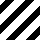
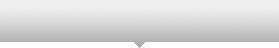
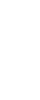
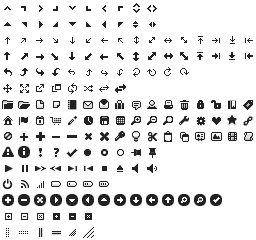
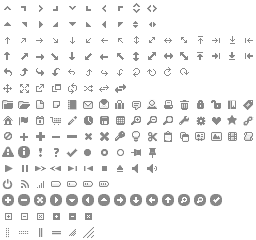
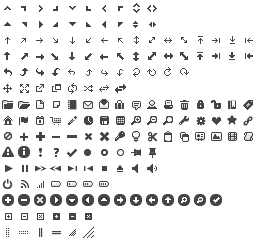
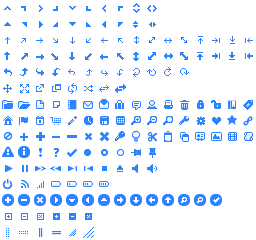
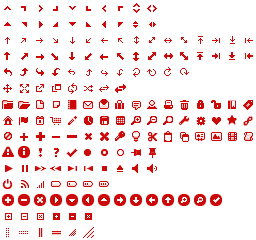
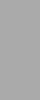
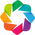
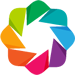
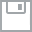
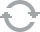
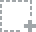
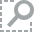
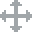
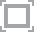
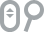

In [1]:
# Show the plots after they are generated in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

# Just some temporary messy things to deal with the project path
import os.path
import sys
sys.path.extend([os.path.dirname(os.path.dirname(os.path.abspath(os.path.curdir)))])

# Interactive Plots (more to come on these)
import bokeh
import bokeh.plotting as bk
bk.output_notebook()

# Statistical Plotting
import seaborn as sns
sns.mpl.rcParams['figure.figsize'] = (16, 10)

####Import the Formula1 Utilities
* Ergast API for Formula1
* Utility for finding indices for pit laps, and filtering outlier lap times
* Plotting Utilities (reused as methods on Laps class)

In [2]:
from formulapy.data.ergast import Formula1
from formulapy.data_utils import pit_laps, filter_pit_laps
from formulapy.plots import lap_box_plot, lap_dist_plot

# Just make this shorter for convenience
f1 = Formula1

---
#1. Accessing Data

Each list of things is a wrapper around python objects that represent the "thing", that are made to easily convert to Pandas DataFrames. Most operations are passed down to the Pandas DataFrame for displaying interactively and filtering. For example, viewing the seasons looks like this:

###Introduction

In [3]:
f1.seasons.tail()

,season
61,2011
62,2012
63,2013
64,2014
65,2015


However, it isn't actually a Pandas DataFrame. This is useful for providing custom behaviors on the DataFrame.

In [4]:
type(f1.seasons)

formulapy.core.Seasons

You can always access the DataFrame by appending `.df` to the group.

In [5]:
type(f1.seasons.df)

pandas.core.frame.DataFrame

Using dot notation, FormulaPy will collect data only as you request it, while you are drilling down. In an IPython Notebook, this looks like this:
![](http://i.imgur.com/EJAgBP6.png)

###Preview the Race Information for 2015

In [6]:
f1.seasons.s2015.races.head()

,circuitId,circuitName,city,country,date,lat,long,name,round,season,time
0,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,2015-03-15 05:00:00,-37.84970,144.96800,Australian Grand Prix,1,2015,05:00:00
1,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2015-03-29 07:00:00,2.76083,101.73800,Malaysian Grand Prix,2,2015,07:00:00
2,shanghai,Shanghai International Circuit,Shanghai,China,2015-04-12 06:00:00,31.33890,121.22000,Chinese Grand Prix,3,2015,06:00:00
3,bahrain,Bahrain International Circuit,Sakhir,Bahrain,2015-04-19 15:00:00,26.03250,50.51060,Bahrain Grand Prix,4,2015,15:00:00
4,catalunya,Circuit de Catalunya,Montmeló,Spain,2015-05-10 12:00:00,41.57000,2.26111,Spanish Grand Prix,5,2015,12:00:00


###Store Out the Bahrain Lap Data for Later Use

In [7]:
df = f1.seasons.s2015.races.BahrainGrandPrix_4.laps.df
df.head()

,driverId,lap_number,position,seconds,time
0,hamilton,1,1,101.390,00:01:41.390000
1,vettel,1,2,102.217,00:01:42.217000
2,raikkonen,1,3,102.896,00:01:42.896000
3,rosberg,1,4,103.381,00:01:43.381000
4,bottas,1,5,104.432,00:01:44.432000


---
#2. Manual Data Manipulation and Plotting
Often you will want to add additional information (features) to the data, for visualization and/or further analysis. The DataFrame makes this easy.

Let's add the difference in time between each driver's lap, and the total sum of lap times for each of their laps. The GroupBy function provides a way to conveniently apply these operations to each "group" of data that makes sense. In this case, we need to group by the `driverId`.

In [8]:
df.ix[:, 'time_diff'] = df.groupby('driverId').seconds.diff()
df.ix[:, 'total_seconds'] = df.groupby('driverId').seconds.cumsum()
df.head()

,driverId,lap_number,position,seconds,time,time_diff,total_seconds
0,hamilton,1,1,101.390,00:01:41.390000,NaN,101.390
1,vettel,1,2,102.217,00:01:42.217000,NaN,102.217
2,raikkonen,1,3,102.896,00:01:42.896000,NaN,102.896
3,rosberg,1,4,103.381,00:01:43.381000,NaN,103.381
4,bottas,1,5,104.432,00:01:44.432000,NaN,104.432


###Let's Just Select Kimi
And, lets select his laps where he either increased or decreased his lap time as compared to the previous. This could be helpful for doing future stint/tire wear analysis. We will take a peek at the slower laps.

In [9]:
# Kimi Only
kimi = df.ix[df.driverId == 'raikkonen', :]

# Kimi's Laps Faster Than the Previous
faster = kimi.ix[kimi.time_diff < 0, :]

# Kimi's Laps Slower Than the Previous
slower = kimi.ix[kimi.time_diff > 0, :]
slower.head()

,driverId,lap_number,position,seconds,time,time_diff,total_seconds
60,raikkonen,4,4,102.277,00:01:42.277000,2.425,404.907
117,raikkonen,7,4,100.196,00:01:40.196000,0.140,705.421
136,raikkonen,8,4,100.592,00:01:40.592000,0.396,806.013
155,raikkonen,9,4,101.331,00:01:41.331000,0.739,907.344
193,raikkonen,11,4,101.172,00:01:41.172000,0.106,1109.582


###Interactive Plots
More to come using Bokeh, as it is even better suited for interactive dashboards, but here I demonstrate making some simple interactive plots using it.

In [10]:
fig = bk.figure(title='Bahrain 2015: Kimi Lap Time Changes')
fig.scatter(x=faster.lap_number, y=faster.time_diff, color='green', legend='< previous')
fig.scatter(x=slower.lap_number, y=slower.time_diff, color='red', legend='> previous')
bk.show(fig)

####Compare Driver Laptimes with Indication of When Corresponding Pits Occurred

In [11]:
# only plot these drivers and with corresponding colors
drivers = ['raikkonen', 'hamilton', 'vettel', 'rosberg']
colors = ['red', 'green', 'gold', 'gray']

# create the figure
fig = bk.figure(title='Bahrain 2015: Driver Lap Time Comparison', y_range=[90, 130])

# index of the pit laps
pit_ix = pit_laps(df)

# loop over each driver and plot their laptimes
for driver, color in zip(drivers, colors): 
    driver_df = df.ix[df.driverId == driver, :]
    fig.scatter(x=driver_df.lap_number, y=driver_df.seconds, color=color, legend=driver)
    
    # loop over each driver's pit laps and add an x intercept
    pits = df.ix[((df.driverId == driver) & pit_ix), :]
    for idx, pit in pits.iterrows():
        x, y = [pit.lap_number, pit.lap_number], [-100000, 100000]
        fig.line(x=x, y=y, color=color, alpha=0.6, line_dash='dashed')

bk.show(fig)

###Seaborn for Statistical Plotting

####Plot Distribution of Kimi's Laptimes

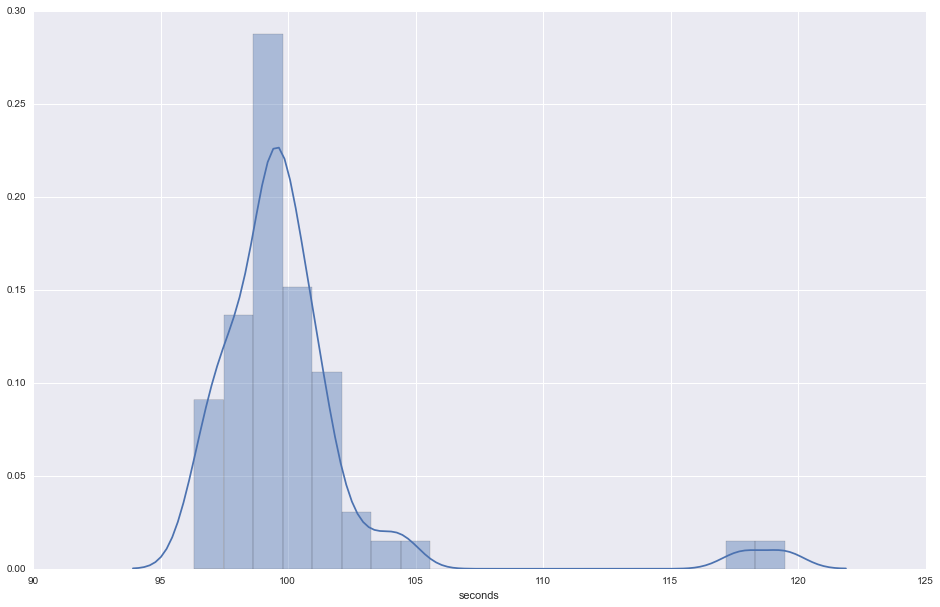

In [12]:
ax = sns.distplot(df.ix[df.driverId == 'raikkonen', 'seconds'])

####Compare Multiple Drivers' Lap TImes
First we will filter out the outlier, out laps, then plot a distribution for each driver we are looking at. 

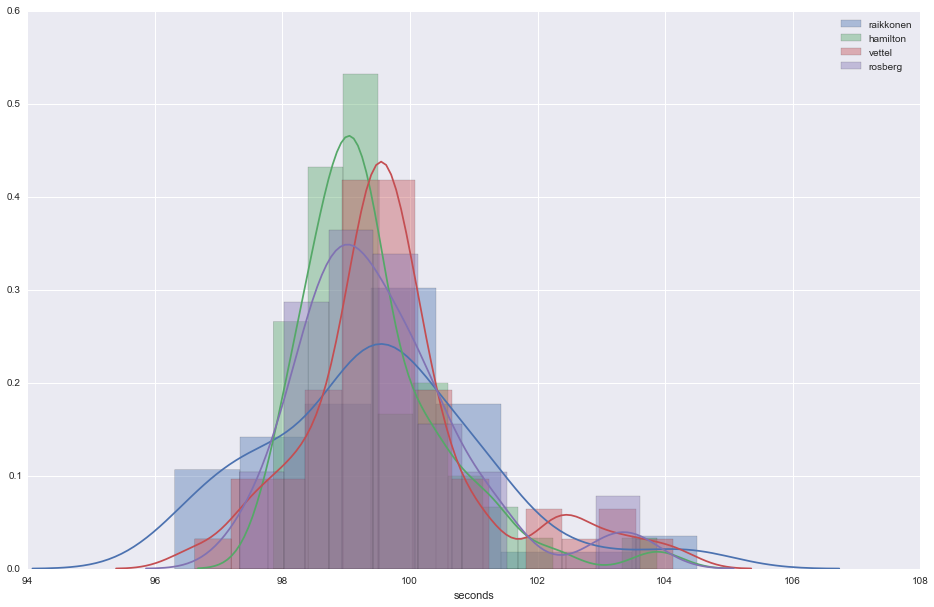

In [13]:
filt_df = filter_pit_laps(df)

for driver in drivers:
    ax = sns.distplot(filt_df.ix[filt_df.driverId == driver, 'seconds'])

ax.legend(drivers)

####That Works OK, but Not Ideal for Comparing Many Distributions. Enter, the Box Plot.
The box plot summarizes the key components of a distribution of values. The relationship between the box features and the values (src: Wikipedia) are shown below:
<img src="http://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Boxplot_vs_PDF.svg/598px-Boxplot_vs_PDF.svg.png" height="600">

Use seaborn to create a boxplot of the Bahrain laptimes, grouped by driver id.

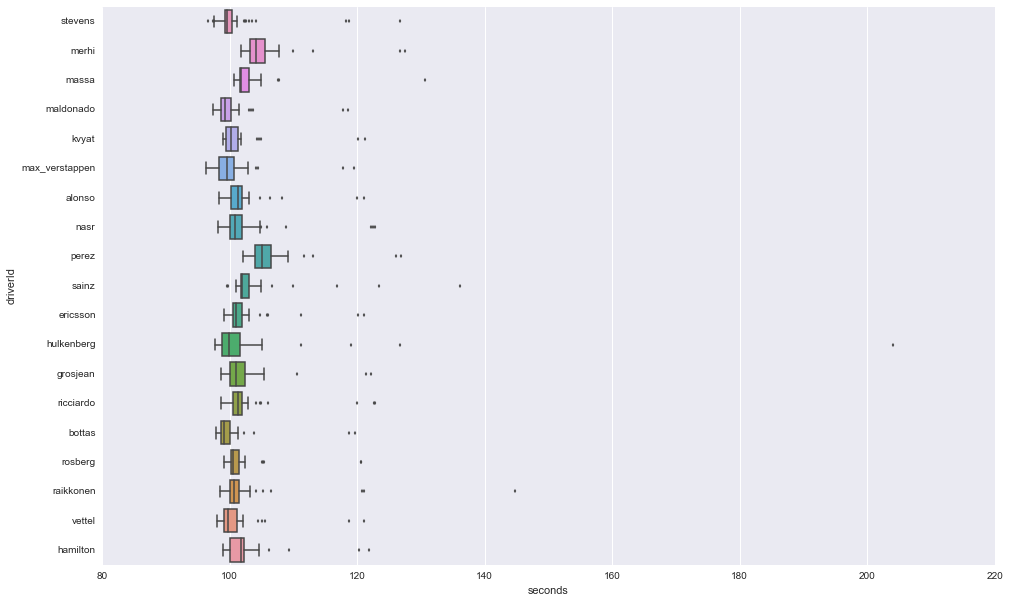

In [14]:
sns.boxplot(df.seconds, df.driverId, names=df.driverId.unique(), vert=False)

---
#3. Convenience Functions for Quick Plotting

###Pre-Configured Box Plot for Lap Times
To save the time it takes to perform the ordering operations, filtering, labels, etc, I have a function that can perform that in a consistent way.

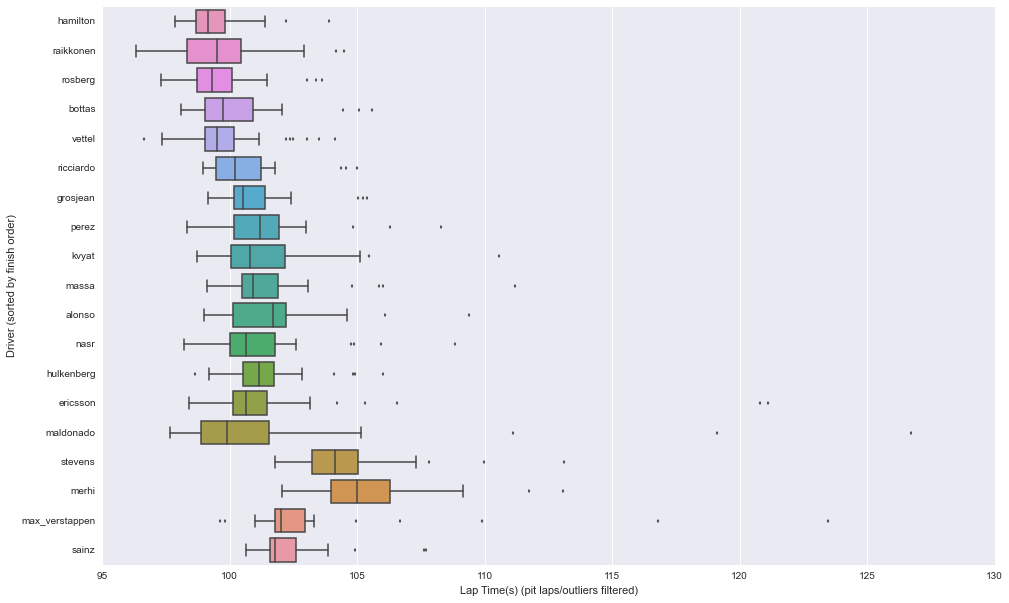

In [15]:
lap_box_plot(df, pit_laps=False)

###Also a Version of the Distribution Plot
Just need to pass it the laps dataframe, a list of drivers to compare, and whether to filter pit laps (default is not to filter).

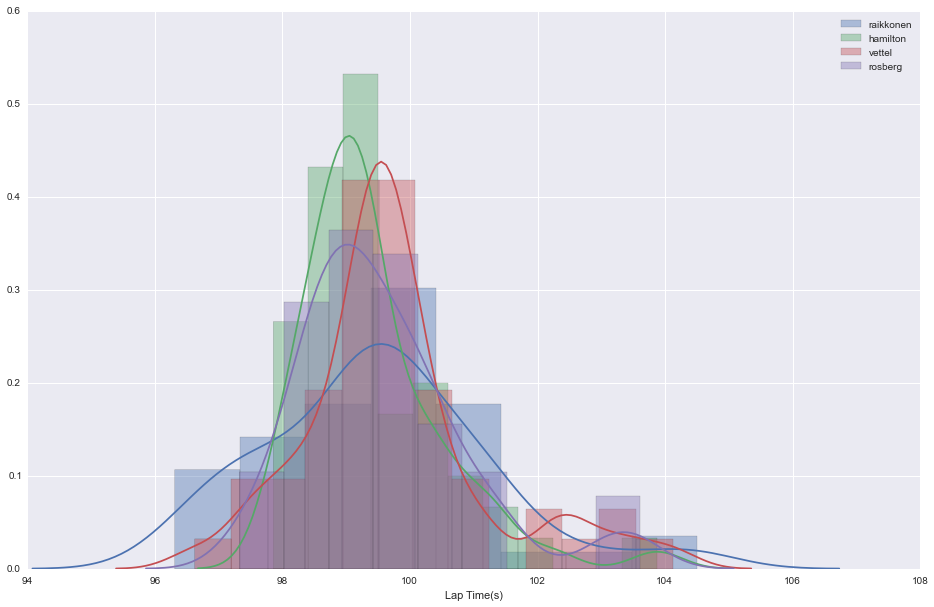

In [16]:
lap_dist_plot(df, drivers, pit_laps=False)

###Combining API with Convenient Plotting
Some of the plot types can be integrated in as methods to the classes, which can reduce some of the boilerplate required to produce quick plots.

Here, I start by selecting only the first 4 races of 2015

In [17]:
races = f1.seasons.s2015.races[0:4]
races

,circuitId,circuitName,city,country,date,lat,long,name,round,season,time
0,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,2015-03-15 05:00:00,-37.84970,144.9680,Australian Grand Prix,1,2015,05:00:00
1,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2015-03-29 07:00:00,2.76083,101.7380,Malaysian Grand Prix,2,2015,07:00:00
2,shanghai,Shanghai International Circuit,Shanghai,China,2015-04-12 06:00:00,31.33890,121.2200,Chinese Grand Prix,3,2015,06:00:00
3,bahrain,Bahrain International Circuit,Sakhir,Bahrain,2015-04-19 15:00:00,26.03250,50.5106,Bahrain Grand Prix,4,2015,15:00:00


####Iterate Over Each Race, and Make a Box Plot

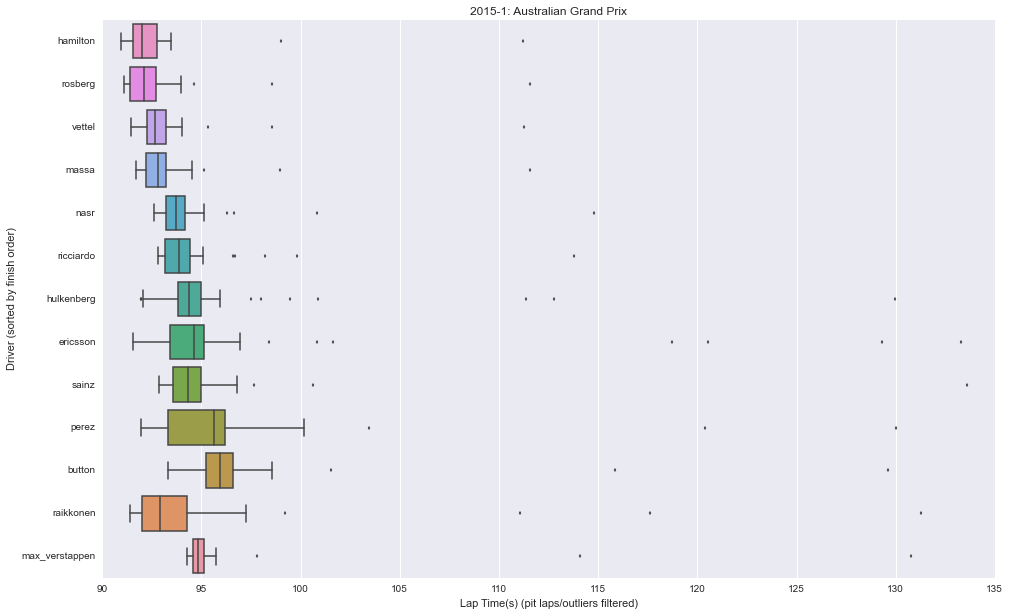

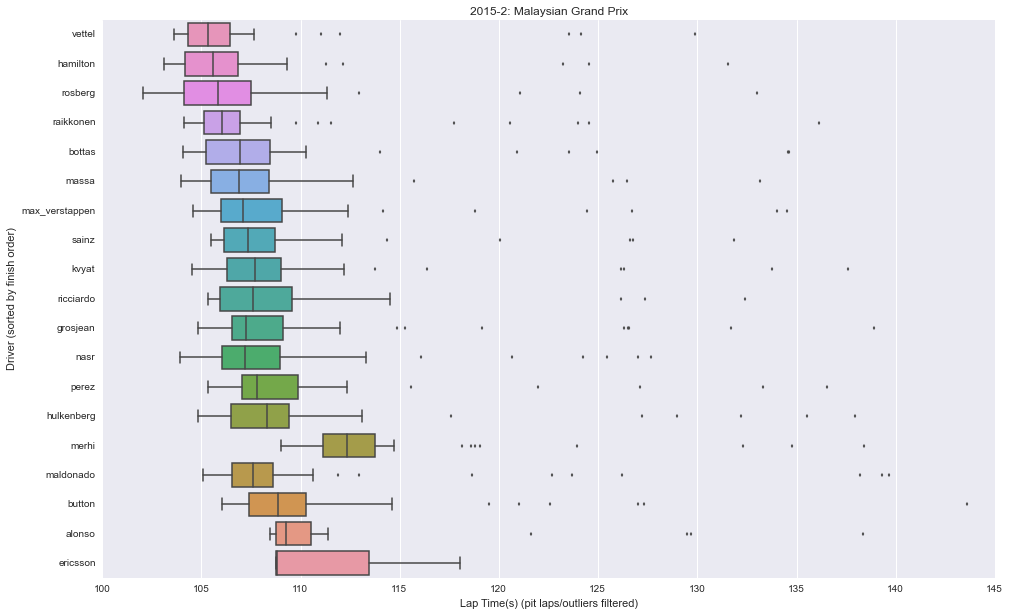

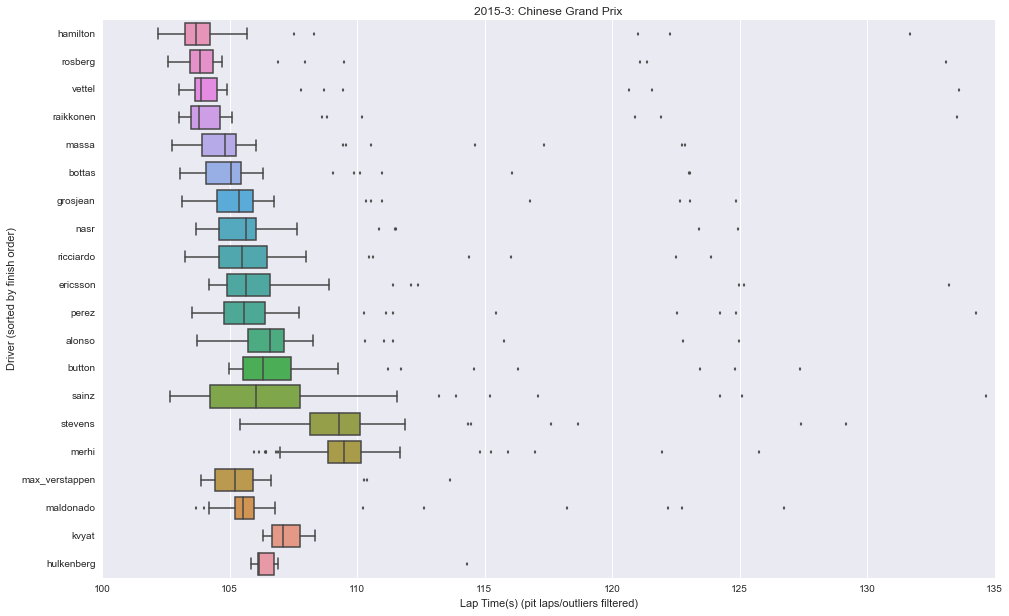

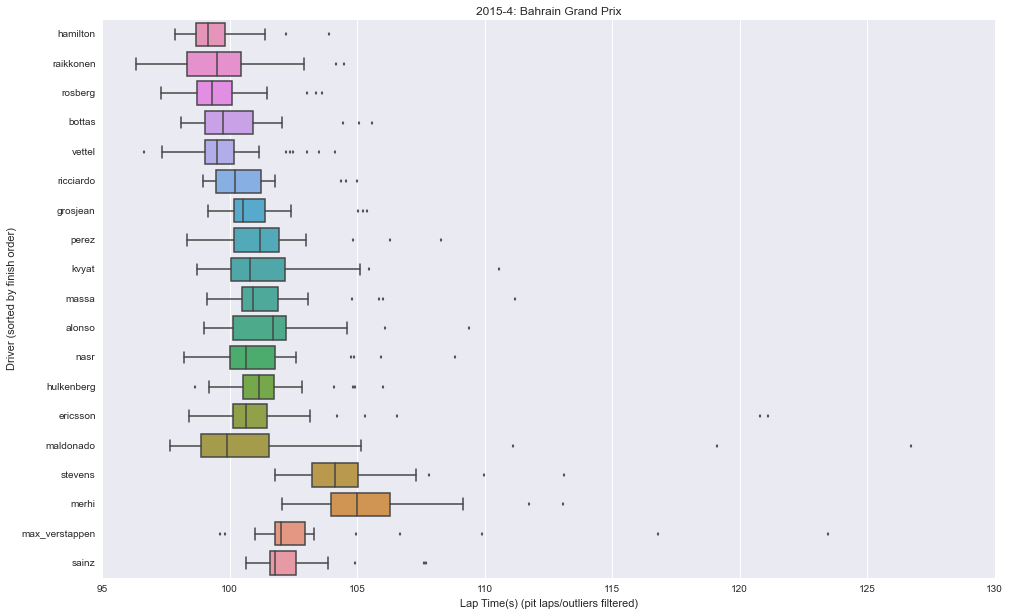

In [18]:
for race in races:
    ax = race.laps.driver_box_plot(pit_laps=False)
    plt.show(ax)

---
#4. Analysis Takeaways
Nothing significant, but more to come with some statistical modeling. You can find these in the above charts.

* Intuitively, Hamilton stands out as both consistent and fast (see bar charts/dist charts)
* Malaysia's temperatures show greater variance across all teams, with Ferrari faring the best (see last bar charts)
* Mercedes and Ferrari look a lot closer to each other, than any others look like them
* You could pick out Manor quite easily without labeling the drivers